In [5]:
# python imports
import h5py
import numpy as np
import ROOT
import json
import sys
import uproot

# custom scripts
from utils.histograms import extended_hist
import utils.rootformatting as rf
rf.atlasstyle()

# root settings
palette=(70,0,1)           
ROOT.gStyle.SetPalette(palette[0],palette[1],palette[2])
ROOT.gStyle.SetGridStyle(1)
ROOT.gStyle.SetGridWidth(1)

def makeHist(name, binValues, binValuesStatErrs, binLow, binWidth):
    h = ROOT.TH1D(name, "", len(binValues), binLow, float(len(binValues))*binWidth+binLow)
    for (iBin, val) in enumerate(binValues):
        h.SetBinContent(iBin+1, val)
        h.SetBinError(iBin+1, binValuesStatErrs[iBin])
    return h

In [75]:
# settings
samples = {
	"data" : ["data", ROOT.kBlack], # black
	"ttbar" : ["t#bar{t}", ROOT.kRed], # red
	"Wt" : ["tW", ROOT.kOrange],
	"WW" : ["WW", ROOT.kGreen],
	"Zee" : ["Z#rightarrowee", ROOT.kBlue],
	"Zmumu": ["Z#rightarrow#mu#mu", ROOT.kBlue],
	"Ztautau": ["Z#rightarrow#tau#tau", ROOT.kBlue],
	"fake" : ["fake", ROOT.kViolet]
}
norm = True

In [171]:
# load data
inFileName = "/home/abadea/analysis/ttbarPbPb/AnalysisTop/run/TRExFitter/input/PbPbv30/hists.root"
f = uproot.open(inFileName)

# bin settings
limits = [0,330]
binWidth = 15
nbins = int((limits[1]-limits[0])/binWidth)
bins = np.linspace(limits[0],limits[1],nbins+1)
binLow = bins[0]
binCenters = (bins + binWidth/2)[:-1]

# histogram
trees = [i for i in f.keys() if "nominal" in i and "emu" in i]
H = {}
for t in trees:
    
    # load
    sample = t.split("-nominal")[0].split("emu-")[1]
    label, color = samples[sample]
    mll = np.array(f[t]['mll'].array()).flatten()
    w = np.array(f[t]['weight'].array()).flatten()
    # cuts
    llpt = np.array(f[t]['llpt'].array())
    cut = (llpt > 40) 
    # histogram and normalize
    binValues, binValuesStatErrs, bin_centers, bin_edges = extended_hist(x=mll[cut], nbins=nbins, limits=limits, underflow=False, overflow=False, weights=w[cut])
    H[sample] = makeHist(f"h_{sample}", binValues, binValuesStatErrs, binLow, binWidth)
    if norm: 
        try:
            H[sample].Scale(1./H[sample].Integral())
        except:
            print(sample, H[sample].Integral())

Zee 0.0
Zmumu 0.0


Warning in <TROOT::Append>: Replacing existing TH1: h_fake (Potential memory leak).


Zee 0.0
Zmumu 0.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file mll.pdf has been created


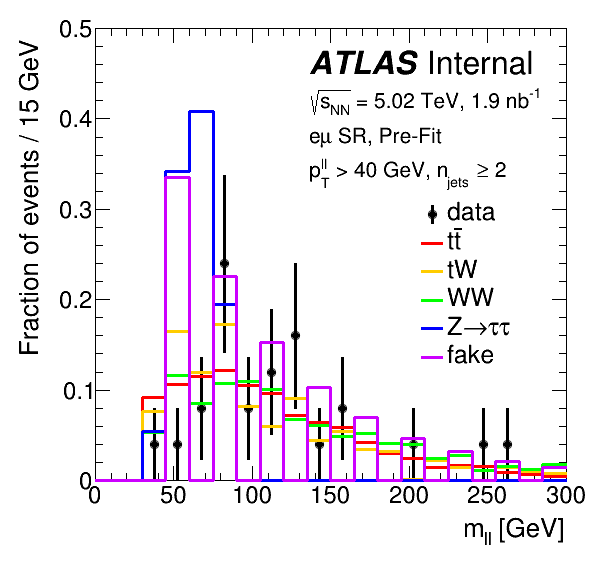

In [176]:
# hist style
style1d = { 
    "title": "",
    "x_title_offset": 1.1,
    "x_label_size": 0.045,
    "y_title_offset": 1.4,
    "y_label_size": 0.045,
    "title_font": 42,
    "label_font": 42,
    "fill_color": 0,
    "x_title":"m_{ll} [GeV]",
    "y_title":f"Fraction of events / {binWidth} GeV",
    "y_n_divisions" : 808,
    "x_n_divisions" : 808,
}
ROOT.gStyle.SetGridStyle(2)
ROOT.gStyle.SetGridWidth(1)

c = ROOT.TCanvas("c","",0,0,600,600)

# legend
l, lw = 0.7, 0.2 # left, left + width
t, tw = 0.65, 0.3 # top, top - width
leg = ROOT.TLegend(l, t-tw, l+lw, t)
leg.SetBorderSize(0)
leg.SetFillColor(0)
leg.SetFillStyle(0)
leg.SetTextFont(42)
leg.SetTextSize(0.048)

# histograms
for sample, h in H.items():
    label, color = samples[sample]
    if h.Integral() == 0:
        print(sample, h.Integral())
        continue
    rf.format_hist(h, **style1d)
    h.GetYaxis().SetRangeUser(0,0.5)
    h.GetXaxis().SetRangeUser(0,300)
    h.SetLineColor(color)
    h.SetLineWidth(3)
    h.GetXaxis().CenterTitle(False)
    h.GetYaxis().CenterTitle(False)
    if sample == "data":
        h.Draw("E1")
        leg.AddEntry(h, label, "pe")
    else:
        h.Draw("hist same")
        leg.AddEntry(h, label, "l")
    
# draw label
left, top, wd, fs = 0.52, 0.87, 0.06, 0.03 # 0.2
stamps = [
    rf.myText(left, top, 1, "#it{#bf{ATLAS}} Internal", 0.06),
    rf.myText(left, top-1*wd, 1, "#sqrt{s_{NN}} = 5.02 TeV, 1.9 nb^{-1}", 0.04),
    rf.myText(left, top-2*wd, 1, "e#mu SR, Pre-Fit", 0.04),
    rf.myText(left, top-3*wd, 1, "p_{T}^{ll} > 40 GeV, n_{jets} #geq 2", 0.04),
    # rf.myText(left+0.1, top-3*wd, 1, "#geq 2 jets", 0.04),
]
for stamp in stamps:
    stamp.Draw()

leg.Draw()

c.SaveAs("mll.pdf")
c.Draw()